# REFMAP laboratory listening test 1 analysis: Sound quality analysis

## Setup

In [24]:
# import statements
import sys
import os
import numpy as np
import pandas as pd
from PyQt5.QtWidgets import QFileDialog, QApplication
from scipy import stats
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pingouin as pg
from cycler import cycler

In [3]:
# set plot parameters
sns.set_style('white')
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams.update({'font.size': 16})
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['mathtext.fontset'] = 'stix'

SMALL_SIZE = 9
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE,
       labelsize=MEDIUM_SIZE)    # fontsize of the axes title and x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mycolours = [(0, 102, 255), (0, 204, 153), (255, 0, 102), (74, 111, 152),
             (251, 164, 49), (204, 153, 255), (90, 192, 255), (80, 245, 233),
             (255, 90, 192), (164, 201, 242), (255, 254, 139), (255, 243, 255)]
mycolours = [tuple(shade/255 for shade in colour) for colour in mycolours]

np.random.seed(303)

# enable copy-on-write mode for Pandas (will be default from Pandas 3.0)
pd.options.mode.copy_on_write = True

# select figure output save path
app = QApplication(sys.argv)
outFigPath = QFileDialog.getExistingDirectory(caption=r"Select output folder to save plots")

## Import data and organise

In [434]:
# import test data
fileExts = "*.csv"

# Part A
dataByStimAFilePath = list(QFileDialog.getOpenFileName(filter=fileExts,
                                                       caption=r"Open refmap_listest1_testdataA_ByStim.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
dataByStimTestA = pd.read_csv(dataByStimAFilePath, index_col=0)

# import SQM data
fileExts = "*.xlsx"
filelist = list(QFileDialog.getOpenFileNames(filter=fileExts,
                                             caption=r"Select SQM analysis files in: \03 Experiment\Experiment 1\Analysis\ArtemiS\Output"))[0]
filelist.sort()
filenames = [filepath.split('/')[-1] for filepath in filelist]
A1_SQM = pd.read_excel(io=filelist[0], sheet_name=None)
A2_SQM = pd.read_excel(io=filelist[1], sheet_name=None)
H520_F_1_SQM = pd.read_excel(io=filelist[2], sheet_name=None)
H520_L_1_SQM = pd.read_excel(io=filelist[3], sheet_name=None)
H520_T_1_SQM = pd.read_excel(io=filelist[4], sheet_name=None)
M300_F_1_SQM = pd.read_excel(io=filelist[5], sheet_name=None)
M300_L_1_SQM = pd.read_excel(io=filelist[6], sheet_name=None)
M300_T_1_SQM = pd.read_excel(io=filelist[7], sheet_name=None)
T150_F_1_SQM = pd.read_excel(io=filelist[8], sheet_name=None)
T150_L_1_SQM = pd.read_excel(io=filelist[9], sheet_name=None)
T150_T_1_SQM = pd.read_excel(io=filelist[10], sheet_name=None)


## Stimuli sound quality analysis

### Time-aggregated

Below is a function that generates a radar (spider) plot with varying axis scalings.

In [448]:
def spider(df, *, id_column, title=None, max_values=None, padding=1.25, axsize=12, labelsize=12, legsize=12, palette=None,
           savefigpath=False, savefigfmt='svg'):
    categories = df._get_numeric_data().columns.tolist()
    data = df[categories].to_dict(orient='list')
    ids = df[id_column].tolist()
    if max_values is None:
        max_values = {key: padding*max(value) for key, value in data.items()}
    else:
        keys = [key for key in data.keys()]
        values =  [max_value for max_value in max_values]
        max_values = dict(map(lambda i, j: (i, j), keys, values))
    
    normalized_data = {key: np.array(value) / max_values[key] for key, value in data.items()}
    num_vars = len(data.keys())
    tiks = list(data.keys())
    tiks += tiks[:1]
    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist() + [0]
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    if palette is None:
        pass
    else:
        try:
            ax.set_prop_cycle(cycler(color=palette))
        except TypeError:
            raise TypeError


    for ii, model_name in enumerate(ids):
        values = [normalized_data[key][ii] for key in data.keys()]
        actual_values = [data[key][ii] for key in data.keys()]
        values += values[:1]  # Close the plot for a better look
        ax.plot(angles, values, label=model_name)
        ax.fill(angles, values, alpha=0.15)
        
        for _x, _y, t in zip(angles, values, actual_values):
            t = f'{t:.3f}' if isinstance(t, float) else str(t)
            ax.text(_x, _y, t, size=labelsize)

            
    ax.fill(angles, np.ones(num_vars + 1), alpha=0.01)
    ax.set_yticklabels([])
    ax.set_xticks(angles)
    ax.set_xticklabels(tiks, fontsize=axsize)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=legsize)
    if title is not None: plt.suptitle(title)
    if savefigpath != False:
        try:
            plt.savefig(savefigpath, format=savefigfmt)
        except ValueError:
            raise ValueError
    plt.show()

In [436]:
# prepare subdata frame 
df_SQM = dataByStimTestA.loc[(dataByStimTestA['AmbientEnv'] == "Park") &
                              (dataByStimTestA['UASLAeq'] == "60"),
                              ['UASType', 'UASOperation',
                               'UASLoudECMAHMSPowAvgBin', 'UASSharpAuresISO3PowAvgMaxLR',
                               'UASTonalECMAHMS05ExMaxLR', 'UASFluctstrHMS10ExBin',
                               'UASRoughECMAHMS10ExBin', 'UASImpulsHMSMaxMaxLR']]


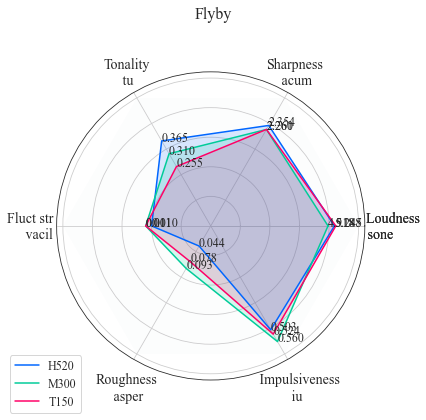

In [455]:
data=pd.DataFrame({
        'UASType': df_SQM['UASType'].unique(),
        '        Loudness\n sone': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), 'UASLoudECMAHMSPowAvgBin'].values, 3),
        'Sharpness\n acum\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), 'UASSharpAuresISO3PowAvgMaxLR'].values, 3),
        'Tonality\n tu\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), 'UASTonalECMAHMS05ExMaxLR'].values, 3),
        'Fluct str       \n vacil   ': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), 'UASFluctstrHMS10ExBin'].values, 3),
        '\n\nRoughness\n asper': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), 'UASRoughECMAHMS10ExBin'].values, 3),
        '\n\n   Impulsiveness\n iu': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), 'UASImpulsHMSMaxMaxLR'].values, 3)
    })
spider(
    data,
    id_column='UASType',
    title='Flyby',
    max_values=[6.2, 3, 0.55, 0.025, 0.28, 0.62],
    padding=1.15,
    axsize=14,
    palette=mycolours,
    savefigpath=os.path.join(outFigPath, "UASSQMFlyby.svg")
)


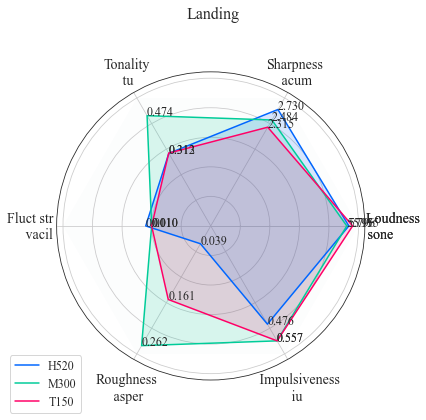

In [454]:
data=pd.DataFrame({
        'UASType': df_SQM['UASType'].unique(),
        '        Loudness\n sone': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), 'UASLoudECMAHMSPowAvgBin'].values, 3),
        'Sharpness\n acum\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), 'UASSharpAuresISO3PowAvgMaxLR'].values, 3),
        'Tonality\n tu\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), 'UASTonalECMAHMS05ExMaxLR'].values, 3),
        'Fluct str       \n vacil   ': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), 'UASFluctstrHMS10ExBin'].values, 3),
        '\n\nRoughness\n asper': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), 'UASRoughECMAHMS10ExBin'].values, 3),
        '\n\n   Impulsiveness\n iu': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), 'UASImpulsHMSMaxMaxLR'].values, 3)
    })
spider(
    data,
    id_column='UASType',
    title='Landing',
    max_values=[6.2, 3, 0.55, 0.025, 0.28, 0.62],
    padding=1.15,
    axsize=14,
    palette=mycolours,
    savefigpath=os.path.join(outFigPath, "UASSQMLanding.svg")
)

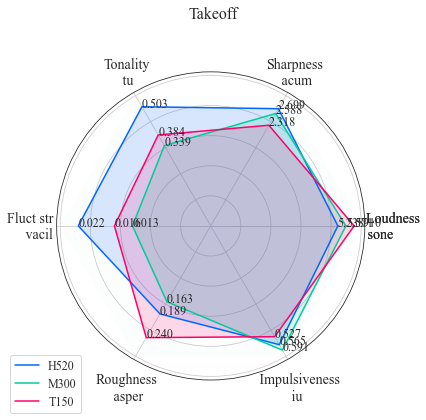

In [453]:
data=pd.DataFrame({
        'UASType': df_SQM['UASType'].unique(),
        '        Loudness\n sone': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), 'UASLoudECMAHMSPowAvgBin'].values, 3),
        'Sharpness\n acum\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), 'UASSharpAuresISO3PowAvgMaxLR'].values, 3),
        'Tonality\n tu\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), 'UASTonalECMAHMS05ExMaxLR'].values, 3),
        'Fluct str       \n vacil   ': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), 'UASFluctstrHMS10ExBin'].values, 3),
        '\n\nRoughness\n asper': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), 'UASRoughECMAHMS10ExBin'].values, 3),
        '\n\n   Impulsiveness\n iu': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), 'UASImpulsHMSMaxMaxLR'].values, 3)
    })
spider(
    data,
    id_column='UASType',
    title='Takeoff',
    max_values=[6.2, 3, 0.55, 0.025, 0.28, 0.62],
    padding=1.15,
    axsize=14,
    palette=mycolours,
    savefigpath=os.path.join(outFigPath, "UASSQMTakeoff.svg")
)

### Time-dependent

#### Loudness

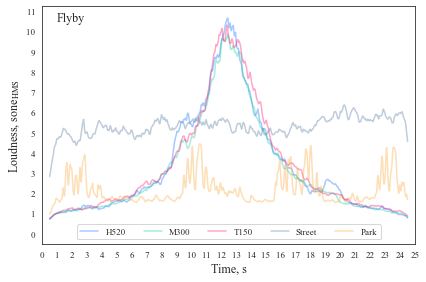

In [320]:
# flyby
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_F_1_SQM, M300_F_1_SQM, T150_F_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet1'].iloc[13, 1:]
    # left channel
    specLoudnessHMSL = pd.DataFrame(workbookdata['Sheet1'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet1'].iloc[13, 1:],
                                    index=workbookdata['Sheet1'].iloc[14:, 0])
    # # right channel
    specLoudnessHMSR = pd.DataFrame(workbookdata['Sheet2'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet2'].iloc[13, 1:],
                                    index=workbookdata['Sheet2'].iloc[14:, 0])
    # # binaural specific loudness (ECMA-418-2:2022 Equation 118)
    specLoudnessHMSBin = ((specLoudnessHMSL**2
                           + specLoudnessHMSR**2)/2).pow(1/2)
    # # binaural time-dependent loudness (ECMA-418-2:2022 Equation 116)
    loudnessHMSTimeVar = specLoudnessHMSBin.sum(axis=0)*0.5

    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], loudnessHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=range(0, 12), xlim=[0, 25], ylim=[-0.5, 11.25],
       xlabel="Time, s", ylabel="Loudness, sone$_\mathrm{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='lower center')
ax.text(x=1, y=10.5, s="Flyby", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtALoudtDepFlyby.svg"), format='svg')
plt.show()

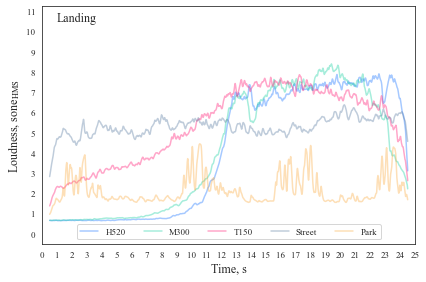

In [321]:
# landing
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_L_1_SQM, M300_L_1_SQM, T150_L_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet1'].iloc[13, 1:]
    # left channel
    specLoudnessHMSL = pd.DataFrame(workbookdata['Sheet1'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet1'].iloc[13, 1:],
                                    index=workbookdata['Sheet1'].iloc[14:, 0])
    # # right channel
    specLoudnessHMSR = pd.DataFrame(workbookdata['Sheet2'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet2'].iloc[13, 1:],
                                    index=workbookdata['Sheet2'].iloc[14:, 0])
    # # binaural specific loudness (ECMA-418-2:2022 Equation 118)
    specLoudnessHMSBin = ((specLoudnessHMSL**2
                           + specLoudnessHMSR**2)/2).pow(1/2)
    # # binaural time-dependent loudness (ECMA-418-2:2022 Equation 116)
    loudnessHMSTimeVar = specLoudnessHMSBin.sum(axis=0)*0.5

    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], loudnessHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=range(0, 12), xlim=[0, 25], ylim=[-0.5, 11.25],
       xlabel="Time, s", ylabel="Loudness, sone$_\mathrm{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='lower center')
ax.text(x=1, y=10.5, s="Landing", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtALoudtDepLanding.svg"), format='svg')
plt.show()

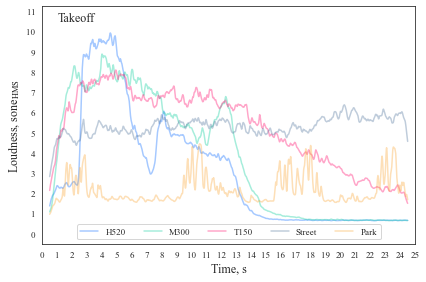

In [322]:
# takeoff
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_T_1_SQM, M300_T_1_SQM, T150_T_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet1'].iloc[13, 1:]
    # left channel
    specLoudnessHMSL = pd.DataFrame(workbookdata['Sheet1'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet1'].iloc[13, 1:],
                                    index=workbookdata['Sheet1'].iloc[14:, 0])
    # # right channel
    specLoudnessHMSR = pd.DataFrame(workbookdata['Sheet2'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet2'].iloc[13, 1:],
                                    index=workbookdata['Sheet2'].iloc[14:, 0])
    # # binaural specific loudness (ECMA-418-2:2022 Equation 118)
    specLoudnessHMSBin = ((specLoudnessHMSL**2
                           + specLoudnessHMSR**2)/2).pow(1/2)
    # # binaural time-dependent loudness (ECMA-418-2:2022 Equation 116)
    loudnessHMSTimeVar = specLoudnessHMSBin.sum(axis=0)*0.5

    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], loudnessHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=range(0, 12), xlim=[0, 25], ylim=[-0.5, 11.25],
       xlabel="Time, s", ylabel="Loudness, sone$_\mathrm{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='lower center')
ax.text(x=1, y=10.5, s="Takeoff", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtALoudtDepTakeoff.svg"), format='svg')
plt.show()

#### Sharpness

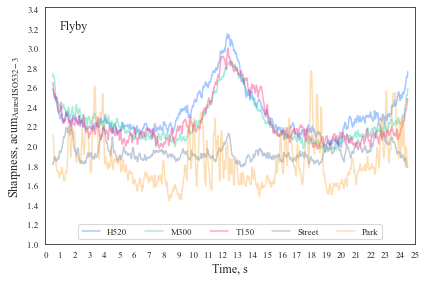

In [323]:
# flyby
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_F_1_SQM, M300_F_1_SQM, T150_F_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet10'].iloc[13:, 0]
    sharpAISO3TimeVar2 = pd.DataFrame(workbookdata['Sheet10'].iloc[13:, 1:3].values,
                                     columns=workbookdata['Sheet10'].iloc[12, 1:3],
                                     index=workbookdata['Sheet10'].iloc[13:, 0])

    whichLR = np.argmax(sharpAISO3TimeVar2.mean(axis=0))
    sharpAISO3TimeVar = sharpAISO3TimeVar2.iloc[:, whichLR]
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], sharpAISO3TimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(1, 4, 0.2), xlim=[0, 25], ylim=[1, 3.425],
       xlabel="Time, s", ylabel="Sharpness, acum$_\mathrm{Aures|ISO532-3}$")
ax.legend(labels=labels, ncol=len(labels), loc='lower center')
ax.text(x=1, y=3.2, s="Flyby", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtASharptDepFlyby.svg"), format='svg')
plt.show()

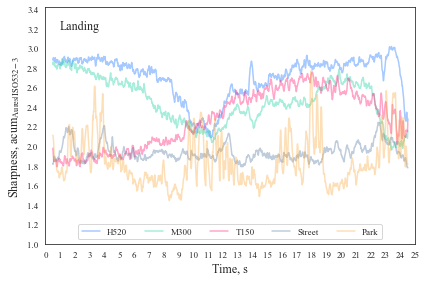

In [324]:
# landing
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_L_1_SQM, M300_L_1_SQM, T150_L_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet10'].iloc[13:, 0]
    sharpAISO3TimeVar2 = pd.DataFrame(workbookdata['Sheet10'].iloc[13:, 1:3].values,
                                     columns=workbookdata['Sheet10'].iloc[12, 1:3],
                                     index=workbookdata['Sheet10'].iloc[13:, 0])

    whichLR = np.argmax(sharpAISO3TimeVar2.mean(axis=0))
    sharpAISO3TimeVar = sharpAISO3TimeVar2.iloc[:, whichLR]
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], sharpAISO3TimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(1, 4, 0.2), xlim=[0, 25], ylim=[1, 3.425],
       xlabel="Time, s", ylabel="Sharpness, acum$_\mathrm{Aures|ISO532-3}$")
ax.legend(labels=labels, ncol=len(labels), loc='lower center')
ax.text(x=1, y=3.2, s="Landing", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtASharptDepLanding.svg"), format='svg')
plt.show()

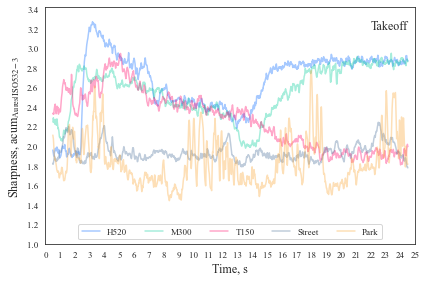

In [325]:
# takeoff
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_T_1_SQM, M300_T_1_SQM, T150_T_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet10'].iloc[13:, 0]
    sharpAISO3TimeVar2 = pd.DataFrame(workbookdata['Sheet10'].iloc[13:, 1:3].values,
                                     columns=workbookdata['Sheet10'].iloc[12, 1:3],
                                     index=workbookdata['Sheet10'].iloc[13:, 0])

    whichLR = np.argmax(sharpAISO3TimeVar2.mean(axis=0))
    sharpAISO3TimeVar = sharpAISO3TimeVar2.iloc[:, whichLR]
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], sharpAISO3TimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(1, 4, 0.2), xlim=[0, 25], ylim=[1, 3.425],
       xlabel="Time, s", ylabel="Sharpness, acum$_\mathrm{Aures|ISO532-3}$")
ax.legend(labels=labels, ncol=len(labels), loc='lower center')
ax.text(x=22, y=3.2, s="Takeoff", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtASharptDepTakeoff.svg"), format='svg')
plt.show()

#### Tonality

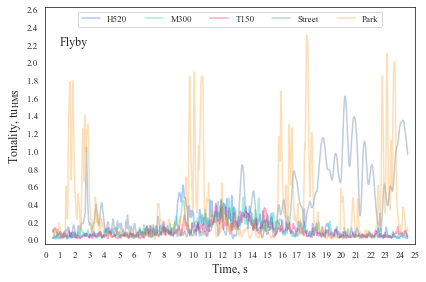

In [326]:
# flyby
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_F_1_SQM, M300_F_1_SQM, T150_F_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet3'].iloc[13, 1:]
    # left channel
    specTonalityHMSL = pd.DataFrame(workbookdata['Sheet3'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet3'].iloc[13, 1:],
                                    index=workbookdata['Sheet3'].iloc[14:, 0])
    # right channel
    specTonalityHMSR = pd.DataFrame(workbookdata['Sheet4'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet4'].iloc[13, 1:],
                                    index=workbookdata['Sheet4'].iloc[14:, 0])
    # 2-channel time-varing tonality (max, not integration)
    tonalityHMSTimeVar2 = pd.concat([specTonalityHMSL.max(axis=0),
                                     specTonalityHMSR.max(axis=0)],
                                     axis=1)
    whichLR = np.argmax(tonalityHMSTimeVar2.mean(axis=0))
    tonalityHMSTimeVar = tonalityHMSTimeVar2.iloc[:, whichLR] 
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], tonalityHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 3, 0.2), xlim=[0, 25], ylim=[-0.05, 2.625],
       xlabel="Time, s", ylabel="Tonality, tu$_\mathrm{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=2.2, s="Flyby", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtATonaltDepFlyby.svg"), format='svg')
plt.show()

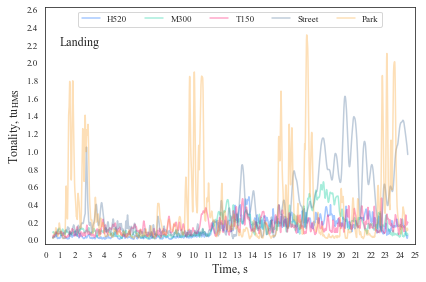

In [327]:
# landing
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_L_1_SQM, M300_L_1_SQM, T150_L_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet3'].iloc[13, 1:]
    # left channel
    specTonalityHMSL = pd.DataFrame(workbookdata['Sheet3'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet3'].iloc[13, 1:],
                                    index=workbookdata['Sheet3'].iloc[14:, 0])
    # right channel
    specTonalityHMSR = pd.DataFrame(workbookdata['Sheet4'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet4'].iloc[13, 1:],
                                    index=workbookdata['Sheet4'].iloc[14:, 0])
    # 2-channel time-varing tonality (max, not integration)
    tonalityHMSTimeVar2 = pd.concat([specTonalityHMSL.max(axis=0),
                                     specTonalityHMSR.max(axis=0)],
                                     axis=1)
    whichLR = np.argmax(tonalityHMSTimeVar2.mean(axis=0))
    tonalityHMSTimeVar = tonalityHMSTimeVar2.iloc[:, whichLR] 
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], tonalityHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 3, 0.2), xlim=[0, 25], ylim=[-0.05, 2.625],
       xlabel="Time, s", ylabel="Tonality, tu$_\mathrm{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=2.2, s="Landing", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtATonaltDepLanding.svg"), format='svg')
plt.show()

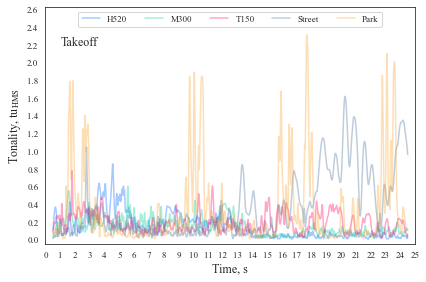

In [328]:
# takeoff
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_T_1_SQM, M300_T_1_SQM, T150_T_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet3'].iloc[13, 1:]
    # left channel
    specTonalityHMSL = pd.DataFrame(workbookdata['Sheet3'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet3'].iloc[13, 1:],
                                    index=workbookdata['Sheet3'].iloc[14:, 0])
    # right channel
    specTonalityHMSR = pd.DataFrame(workbookdata['Sheet4'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet4'].iloc[13, 1:],
                                    index=workbookdata['Sheet4'].iloc[14:, 0])
    # 2-channel time-varing tonality (max, not integration)
    tonalityHMSTimeVar2 = pd.concat([specTonalityHMSL.max(axis=0),
                                     specTonalityHMSR.max(axis=0)],
                                     axis=1)
    whichLR = np.argmax(tonalityHMSTimeVar2.mean(axis=0))
    tonalityHMSTimeVar = tonalityHMSTimeVar2.iloc[:, whichLR] 
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], tonalityHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 3, 0.2), xlim=[0, 25], ylim=[-0.05, 2.625],
       xlabel="Time, s", ylabel="Tonality, tu$_\mathrm{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=2.2, s="Takeoff", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtATonaltDepTakeoff.svg"), format='svg')
plt.show()

#### Fluctuation strength

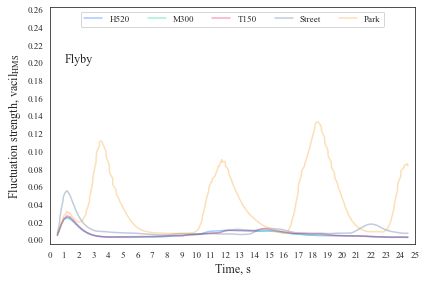

In [329]:
# flyby
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_F_1_SQM, M300_F_1_SQM, T150_F_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet6'].iloc[13, 1:]
    # left channel
    specFluctStrHMSL = pd.DataFrame(workbookdata['Sheet6'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet6'].iloc[13, 1:],
                                    index=workbookdata['Sheet6'].iloc[14:, 0])
    # right channel
    specFluctStrHMSR = pd.DataFrame(workbookdata['Sheet7'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet7'].iloc[13, 1:],
                                    index=workbookdata['Sheet7'].iloc[14:, 0])
    # binaural specific fluctuation strength
    # (using ECMA-418-2:2022 Equation 112 for roughness)
    specFluctStrHMSBin = ((specFluctStrHMSL**2
                           + specFluctStrHMSR**2)/2).pow(1/2)
    # binaural time-dependent fluctuation strength
    # (using ECMA-418-2:2022 Equation 111 for roughness)
    fluctStrHMSTimeVar = specFluctStrHMSBin.sum(axis=0)*0.5
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], fluctStrHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 0.3, 0.02), xlim=[0, 25], ylim=[-0.005, 0.2625],
       xlabel="Time, s", ylabel="Fluctuation strength, vacil$_\mathrm{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=0.2, s="Flyby", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtAFluctstDepFlyby.svg"), format='svg')
plt.show()

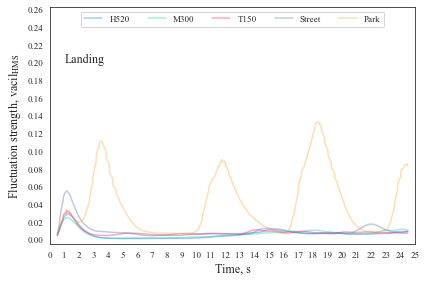

In [330]:
# landing
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_L_1_SQM, M300_L_1_SQM, T150_L_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet6'].iloc[13, 1:]
    # left channel
    specFluctStrHMSL = pd.DataFrame(workbookdata['Sheet6'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet6'].iloc[13, 1:],
                                    index=workbookdata['Sheet6'].iloc[14:, 0])
    # right channel
    specFluctStrHMSR = pd.DataFrame(workbookdata['Sheet7'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet7'].iloc[13, 1:],
                                    index=workbookdata['Sheet7'].iloc[14:, 0])
    # binaural specific fluctuation strength
    # (using ECMA-418-2:2022 Equation 112 for roughness)
    specFluctStrHMSBin = ((specFluctStrHMSL**2
                           + specFluctStrHMSR**2)/2).pow(1/2)
    # binaural time-dependent fluctuation strength
    # (using ECMA-418-2:2022 Equation 111 for roughness)
    fluctStrHMSTimeVar = specFluctStrHMSBin.sum(axis=0)*0.5
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], fluctStrHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 0.3, 0.02), xlim=[0, 25], ylim=[-0.005, 0.2625],
       xlabel="Time, s", ylabel="Fluctuation strength, vacil$_\mathrm{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=0.2, s="Landing", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtAFluctstDepLanding.svg"), format='svg')
plt.show()

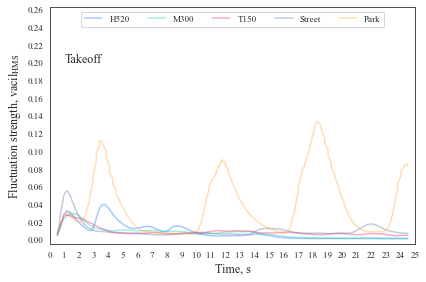

In [331]:
# takeoff
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_T_1_SQM, M300_T_1_SQM, T150_T_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet6'].iloc[13, 1:]
    # left channel
    specFluctStrHMSL = pd.DataFrame(workbookdata['Sheet6'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet6'].iloc[13, 1:],
                                    index=workbookdata['Sheet6'].iloc[14:, 0])
    # right channel
    specFluctStrHMSR = pd.DataFrame(workbookdata['Sheet7'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet7'].iloc[13, 1:],
                                    index=workbookdata['Sheet7'].iloc[14:, 0])
    # binaural specific fluctuation strength
    # (using ECMA-418-2:2022 Equation 112 for roughness)
    specFluctStrHMSBin = ((specFluctStrHMSL**2
                           + specFluctStrHMSR**2)/2).pow(1/2)
    # binaural time-dependent fluctuation strength
    # (using ECMA-418-2:2022 Equation 111 for roughness)
    fluctStrHMSTimeVar = specFluctStrHMSBin.sum(axis=0)*0.5
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], fluctStrHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 0.3, 0.02), xlim=[0, 25], ylim=[-0.005, 0.2625],
       xlabel="Time, s", ylabel="Fluctuation strength, vacil$_\mathrm{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=0.2, s="Takeoff", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtAFluctstDepTakeoff.svg"), format='svg')
plt.show()

#### Roughness

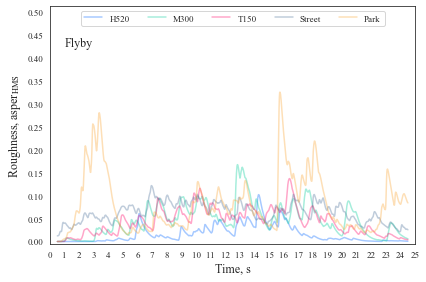

In [332]:
# flyby
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_F_1_SQM, M300_F_1_SQM, T150_F_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet5'].iloc[13, 1:]
    # binaural specific roughness
    specRoughHMSBin = pd.DataFrame(workbookdata['Sheet5'].iloc[14:, 1:].values,
                                   columns=workbookdata['Sheet5'].iloc[13, 1:],
                                   index=workbookdata['Sheet5'].iloc[14:, 0])
    # binaural time-varying roughness
    roughHMSTimeVar = specRoughHMSBin.sum(axis=0)*0.5
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], roughHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 0.55, 0.05), xlim=[0, 25], ylim=[-0.005, 0.5125],
       xlabel="Time, s", ylabel="Roughness, asper$_\mathrm{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=0.425, s="Flyby", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtARoughtDepFlyby.svg"), format='svg')
plt.show()

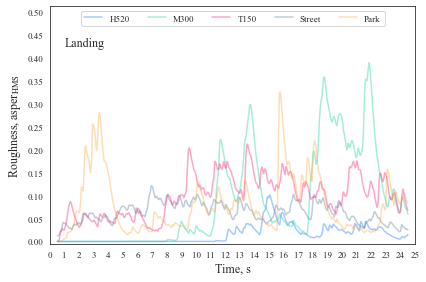

In [334]:
# landing
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_L_1_SQM, M300_L_1_SQM, T150_L_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet5'].iloc[13, 1:]
    # binaural specific roughness
    specRoughHMSBin = pd.DataFrame(workbookdata['Sheet5'].iloc[14:, 1:].values,
                                   columns=workbookdata['Sheet5'].iloc[13, 1:],
                                   index=workbookdata['Sheet5'].iloc[14:, 0])
    # binaural time-varying roughness
    roughHMSTimeVar = specRoughHMSBin.sum(axis=0)*0.5
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], roughHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 0.55, 0.05), xlim=[0, 25], ylim=[-0.005, 0.5125],
       xlabel="Time, s", ylabel="Roughness, asper$_\mathrm{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=0.425, s="Landing", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtARoughtDepLanding.svg"), format='svg')
plt.show()

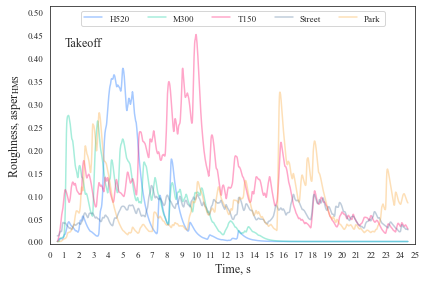

In [335]:
# takeoff
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_T_1_SQM, M300_T_1_SQM, T150_T_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet5'].iloc[13, 1:]
    # binaural specific roughness
    specRoughHMSBin = pd.DataFrame(workbookdata['Sheet5'].iloc[14:, 1:].values,
                                   columns=workbookdata['Sheet5'].iloc[13, 1:],
                                   index=workbookdata['Sheet5'].iloc[14:, 0])
    # binaural time-varying roughness
    roughHMSTimeVar = specRoughHMSBin.sum(axis=0)*0.5
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], roughHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 0.55, 0.05), xlim=[0, 25], ylim=[-0.005, 0.5125],
       xlabel="Time, s", ylabel="Roughness, asper$_\mathrm{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=0.425, s="Takeoff", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtARoughtDepTakeoff.svg"), format='svg')
plt.show()

#### Impulsiveness

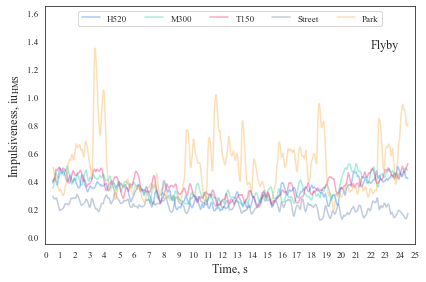

In [347]:
# flyby
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_F_1_SQM, M300_F_1_SQM, T150_F_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet12'].iloc[13:, 0]
    # 2-channel impulsiveness
    impulsiveHMSTimeVar2 = pd.DataFrame(workbookdata['Sheet12'].iloc[13:, 1:3].values,
                                       columns=workbookdata['Sheet12'].iloc[12, 1:3],
                                       index=workbookdata['Sheet12'].iloc[13:, 0])

    whichLR = np.argmax(impulsiveHMSTimeVar2.mean(axis=0))
    impulsiveHMSTimeVar = impulsiveHMSTimeVar2.iloc[:, whichLR]
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], impulsiveHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 2, 0.2), xlim=[0, 25], ylim=[-0.05, 1.65],
       xlabel="Time, s", ylabel="Impulsiveness, iu$_\mathrm{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=22, y=1.35, s="Flyby", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtAImpulstDepFlyby.svg"), format='svg')
plt.show()

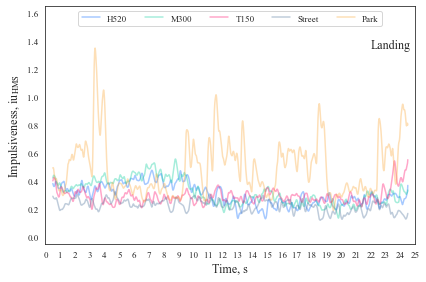

In [355]:
# landing
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_L_1_SQM, M300_L_1_SQM, T150_L_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet12'].iloc[13:, 0]
    # 2-channel impulsiveness
    impulsiveHMSTimeVar2 = pd.DataFrame(workbookdata['Sheet12'].iloc[13:, 1:3].values,
                                       columns=workbookdata['Sheet12'].iloc[12, 1:3],
                                       index=workbookdata['Sheet12'].iloc[13:, 0])

    whichLR = np.argmax(impulsiveHMSTimeVar2.mean(axis=0))
    impulsiveHMSTimeVar = impulsiveHMSTimeVar2.iloc[:, whichLR]
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], impulsiveHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 2, 0.2), xlim=[0, 25], ylim=[-0.05, 1.65],
       xlabel="Time, s", ylabel="Impulsiveness, iu$_\mathrm{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=22, y=1.35, s="Landing", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtAImpulstDepLanding.svg"), format='svg')
plt.show()

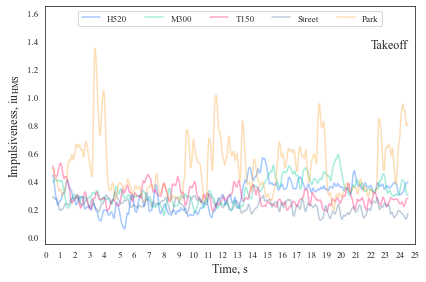

In [348]:
# takeoff
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_T_1_SQM, M300_T_1_SQM, T150_T_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet12'].iloc[13:, 0]
    # 2-channel impulsiveness
    impulsiveHMSTimeVar2 = pd.DataFrame(workbookdata['Sheet12'].iloc[13:, 1:3].values,
                                       columns=workbookdata['Sheet12'].iloc[12, 1:3],
                                       index=workbookdata['Sheet12'].iloc[13:, 0])

    whichLR = np.argmax(impulsiveHMSTimeVar2.mean(axis=0))
    impulsiveHMSTimeVar = impulsiveHMSTimeVar2.iloc[:, whichLR]
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], impulsiveHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 2, 0.2), xlim=[0, 25], ylim=[-0.05, 1.65],
       xlabel="Time, s", ylabel="Impulsiveness, iu$_\mathrm{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=22, y=1.35, s="Takeoff", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtAImpulstDepTakeoff.svg"), format='svg')
plt.show()

### Time-aggregated (repeat)

Radar analysis repeated with ISO 532-3 loudness

In [474]:
# prepare subdata frame 
df_SQM = dataByStimTestA.loc[(dataByStimTestA['AmbientEnv'] == "Park") &
                              (dataByStimTestA['UASLAeq'] == "60"),
                              ['UASType', 'UASOperation',
                               'UASLoudISO3PowAvgMaxLR', 'UASSharpAuresISO3PowAvgMaxLR',
                               'UASTonalECMAHMS05ExMaxLR', 'UASFluctstrHMS10ExBin',
                               'UASRoughECMAHMS10ExBin', 'UASImpulsHMSMaxMaxLR']]


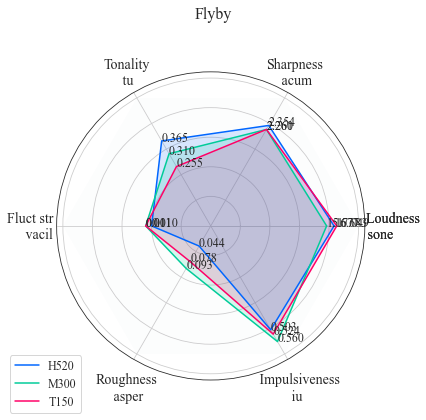

In [479]:
data=pd.DataFrame({
        'UASType': df_SQM['UASType'].unique(),
        '        Loudness\n sone': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), 'UASLoudISO3PowAvgMaxLR'].values, 3),
        'Sharpness\n acum\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), 'UASSharpAuresISO3PowAvgMaxLR'].values, 3),
        'Tonality\n tu\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), 'UASTonalECMAHMS05ExMaxLR'].values, 3),
        'Fluct str       \n vacil   ': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), 'UASFluctstrHMS10ExBin'].values, 3),
        '\n\nRoughness\n asper': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), 'UASRoughECMAHMS10ExBin'].values, 3),
        '\n\n   Impulsiveness\n iu': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), 'UASImpulsHMSMaxMaxLR'].values, 3)
    })
spider(
    data,
    id_column='UASType',
    title='Flyby',
    max_values=[20, 3, 0.55, 0.025, 0.28, 0.62],
    padding=1.15,
    axsize=14,
    palette=mycolours,
    savefigpath=os.path.join(outFigPath, "UASSQMFlybyNISO3.svg")
)


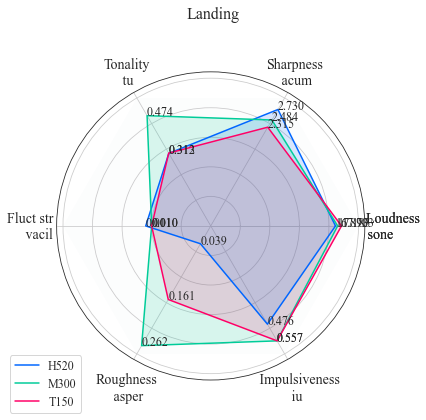

In [480]:
data=pd.DataFrame({
        'UASType': df_SQM['UASType'].unique(),
        '        Loudness\n sone': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), 'UASLoudISO3PowAvgMaxLR'].values, 3),
        'Sharpness\n acum\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), 'UASSharpAuresISO3PowAvgMaxLR'].values, 3),
        'Tonality\n tu\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), 'UASTonalECMAHMS05ExMaxLR'].values, 3),
        'Fluct str       \n vacil   ': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), 'UASFluctstrHMS10ExBin'].values, 3),
        '\n\nRoughness\n asper': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), 'UASRoughECMAHMS10ExBin'].values, 3),
        '\n\n   Impulsiveness\n iu': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), 'UASImpulsHMSMaxMaxLR'].values, 3)
    })
spider(
    data,
    id_column='UASType',
    title='Landing',
    max_values=[20, 3, 0.55, 0.025, 0.28, 0.62],
    padding=1.15,
    axsize=14,
    palette=mycolours,
    savefigpath=os.path.join(outFigPath, "UASSQMLandingNISO3.svg")
)

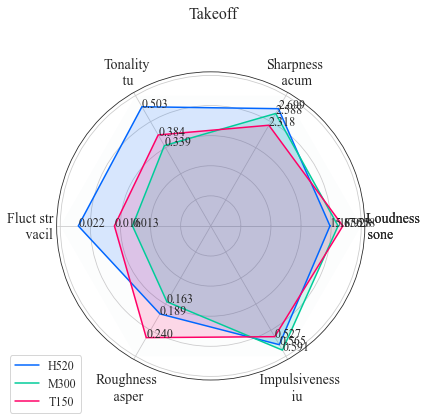

In [481]:
data=pd.DataFrame({
        'UASType': df_SQM['UASType'].unique(),
        '        Loudness\n sone': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), 'UASLoudISO3PowAvgMaxLR'].values, 3),
        'Sharpness\n acum\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), 'UASSharpAuresISO3PowAvgMaxLR'].values, 3),
        'Tonality\n tu\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), 'UASTonalECMAHMS05ExMaxLR'].values, 3),
        'Fluct str       \n vacil   ': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), 'UASFluctstrHMS10ExBin'].values, 3),
        '\n\nRoughness\n asper': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), 'UASRoughECMAHMS10ExBin'].values, 3),
        '\n\n   Impulsiveness\n iu': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), 'UASImpulsHMSMaxMaxLR'].values, 3)
    })
spider(
    data,
    id_column='UASType',
    title='Takeoff',
    max_values=[20, 3, 0.55, 0.025, 0.28, 0.62],
    padding=1.15,
    axsize=14,
    palette=mycolours,
    savefigpath=os.path.join(outFigPath, "UASSQMTakeoffNISO3.svg")
)